In [1]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
#注意下面的%命令只能在jupyter notebook上运行，否则需要删除或注释掉
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

tushare读数据

In [2]:
import tushare as ts
ts.set_token('51a258be54f2339d741ad6733cbafe5cec820eba747bcdb8d759bade')
pro = ts.pro_api()
df = pro.index_daily(ts_code='399300.SZ', start_date='20050408',end_date='20191223')

In [56]:
#由于读出来的数据是时间倒序，因此重排一下
df= df.sort_index(ascending=False)
df.index =np.arange(len(df))
print(df.head)

<bound method NDFrame.head of         ts_code trade_date      close       open       high        low  \
0     399300.SZ   20050408  1003.4450   984.6650  1003.6990   979.5290   
1     399300.SZ   20050411   995.4210  1003.8790  1008.7350   992.7730   
2     399300.SZ   20050412   978.6970   993.7110   993.7110   978.2040   
3     399300.SZ   20050413  1000.9000   987.9500  1006.4990   987.9500   
4     399300.SZ   20050414   986.9750  1004.6400  1006.4160   985.5780   
...         ...        ...        ...        ...        ...        ...   
3574  399300.SZ   20191217  4041.7996  3987.7426  4067.1355  3984.5193   
3575  399300.SZ   20191218  4032.7826  4039.7240  4057.6400  4025.3433   
3576  399300.SZ   20191219  4027.1495  4034.6159  4038.5435  4014.8951   
3577  399300.SZ   20191220  4017.2527  4032.1519  4046.7261  4014.9296   
3578  399300.SZ   20191223  3967.0962  4014.6929  4032.1721  3964.3798   

      pre_close   change  pct_chg          vol        amount       ret  
0      9

计算dpo并画图

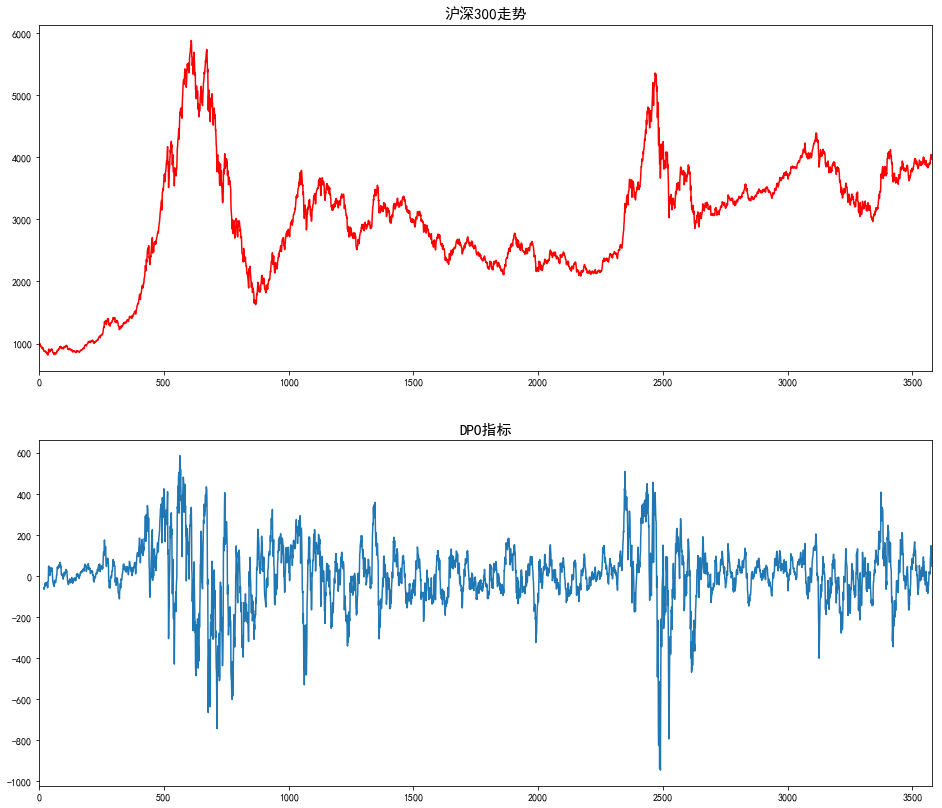

In [57]:
#DPO
def DPO(close):
    """
    计算DPO
    close：收盘价
    """
    N=20
    p = talib.MA(close, timeperiod=N)
    p.shift(11)
    return close-p
df['dpo']=DPO(df['close'])
#画沪深300走势图和DPO指标图
plt.figure(figsize=(16,14))
plt.subplot(211)
df['close'].plot(color='r')
plt.xlabel('')
plt.title('沪深300走势',fontsize=15)
plt.subplot(212)
df['dpo'].plot()
plt.title('DPO指标',fontsize=15)
plt.xlabel('')
plt.show()

评价函数

In [74]:
def performace(transactions,strategy):
    """
    transactions:每笔交易的买卖时点和价格
    strategy：经过策略处理后的df
    """
     # strategy = pdatas.copy();
     N = 250


     # 年化收益率
     rety = strategy.nav[strategy.shape[0] - 1]**(N/strategy.shape[0]) - 1

     # 夏普比
     Sharp = (strategy.ret*strategy.position).mean()/(strategy.ret*strategy.position).std()*np.sqrt(N)


     # 胜率
     VictoryRatio = ((transactions.pricesell - transactions.pricebuy)>0).mean()

     DD = 1 - strategy.nav/strategy.nav.cummax()
     MDD = max(DD)


     # 策略逐年表现

     strategy['year'] = strategy.trade_date.apply(lambda x:x[:4])
     nav_peryear = strategy.nav.groupby(strategy.year).last()/strategy.nav.groupby(strategy.year).first() - 1
     benchmark_peryear = strategy.benchmark.groupby(strategy.year).last()/strategy.benchmark.groupby(strategy.year).first() - 1

     excess_ret = nav_peryear - benchmark_peryear
     result_peryear = pd.concat([nav_peryear,benchmark_peryear,excess_ret],axis = 1)
     result_peryear.columns = ['strategy_ret','bench_ret','excess_ret']
     result_peryear = result_peryear.T

     # 作图 ,nav为策略净值，benchmark为基准净值，RS为相对强弱曲线
     xtick = np.round(np.linspace(0,strategy.shape[0] - 1,7),0)
     xticklabel = strategy.trade_date[xtick]


     plt.figure(figsize = (9,4))
     ax1 = plt.axes()
     plt.plot(np.arange(strategy.shape[0]),strategy.benchmark,'black',label = 'benchmark',linewidth = 2)
     plt.plot(np.arange(strategy.shape[0]),strategy.nav,'red',label = 'nav',linewidth = 2)
     plt.plot(np.arange(strategy.shape[0]),strategy.nav/strategy.benchmark,'orange',label = 'RS',linewidth = 2)

     plt.legend()
     ax1.set_xticks(xtick)
     ax1.set_xticklabels(xticklabel)

     maxloss = min(transactions.pricesell/transactions.pricebuy - 1)
     maxgain=max(transactions.pricebuy/transactions.pricesell.shift(1).fillna(905) - 1)
     print('------------------------------')
     print('夏普比为:',round(Sharp,2))
     print('年化收益率为:{}%'.format(round(rety*100,2)))
     print('胜率为：{}%'.format(round(VictoryRatio*100,2)))
     print('最大回撤率为：{}%'.format(round(MDD*100,2)))
     print('单次最大亏损为:{}%'.format(round(maxloss*100,2)))
     print('单次最大盈利为:{}%'.format(round(maxgain*100,2)))
     print('月均交易次数为：{}(买卖合计)'.format(round(strategy.flag.abs().sum()/strategy.shape[0]*20,2)))

     result = {'Sharp':Sharp,
     'RetYearly':rety,
     'WinRate':VictoryRatio,
     'MDD':MDD,
     'maxlossOnce':-maxloss,
     'num':round(strategy.flag.abs().sum()/strategy.shape[0],1)}

     result = pd.DataFrame.from_dict(result,orient='index').T

     return result,result_peryear

策略函数

------------------------------
夏普比为: 1.12
年化收益率为:20.38%
胜率为：28.49%
最大回撤率为：27.41%
单次最大亏损为:-8.34%
单次最大盈利为:6.96%
月均交易次数为：1.93(买卖合计)
每笔交易的买卖时点和价格
      datebuy   pricebuy  datesell  pricesell
0    20050608   905.7730  20050630   878.6860
1    20050722   859.6930  20050826   928.2580
2    20050901   944.5590  20050921   944.4080
3    20051118   882.2410  20051122   869.6170
4    20051123   876.2290  20051129   871.3100
..        ...        ...       ...        ...
167  20191022  3895.8809  20191023  3871.0848
168  20191025  3896.7923  20191031  3886.7519
169  20191101  3952.3872  20191111  3902.9783
170  20191119  3947.0392  20191120  3907.8641
171  20191206  3902.3853       NaN        NaN

[172 rows x 4 columns]
策略的逐年表现情况
year              2005      2006      2007      2008      2009      2010  \
strategy_ret  0.083857  1.143106  1.126760 -0.107785  0.753663 -0.073196   
bench_ret     0.045579  1.168033  1.582505 -0.662454  0.898971 -0.115118   
excess_ret    0.038279 -0.024927 -0.455744  

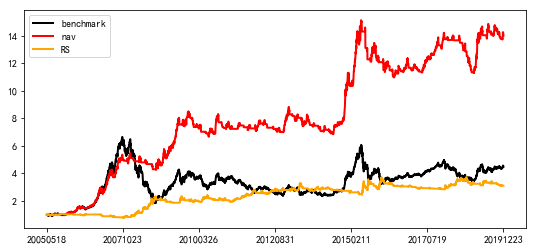

In [75]:
def dpo1(HS300,S1,win_long):
    """
    HS300:标的资产
    S1:策略的阈值
    win_long:
    """
    data  = HS300.copy()
    data['flag'] = 0 # 买卖标记
    data['position'] = 0 # 持仓标记
    position = 0 # 是否持仓，持仓：1，不持仓：0
    pricein=[]
    priceout=[]
    price_in=1
    for i in range(1,data.shape[0]-1):
        
        # 开仓
        #当前日的dpo<0，而当日的dpo>0，且未持仓时，买入信号设置为1,下一期买入
        if data.loc[i,'dpo']>S1 and data.loc[i-1,'dpo']<S1 and position ==0:
            data.loc[i,'flag'] = 1
            data.loc[i+1,'position'] = 1
            position = 1
            date_in = data.trade_date[i]
            price_in = data.loc[i,'close']
            pricein.append([date_in,price_in])
        # 平仓
        #当前日的dpo>0，而当日的dpo<0，且有持仓时，买入信号设置为0,下一期卖出
        elif data.loc[i,'dpo']<S1 and data.loc[i-1,'dpo']>S1 and position ==1: 
            data.loc[i,'flag'] = -1
            data.loc[i+1,'position'] = 0     
            position = 0
            priceout.append([data.trade_date[i],data.loc[i,'close']])
        
        # 保持
        else:
            data.loc[i+1,'position'] = data.loc[i,'position']  
    #记录每笔交易的买卖时点和价格
    p1 = pd.DataFrame(pricein,columns = ['datebuy','pricebuy'])
    p2 = pd.DataFrame(priceout,columns = ['datesell','pricesell'])
    transactions = pd.concat([p1,p2],axis = 1)
 
    data = data.loc[max(0,win_long):,:].reset_index(drop = True)
        
    data['nav'] = (1+data.close.pct_change(1).fillna(0)*data.position).cumprod() #策略净值
    data['benchmark'] =data.close/data.close[0] #基准净值
    data['ret'] = data.close.pct_change(1).fillna(0)
    stats,result_peryear = performace(transactions,data) 
    return stats,result_peryear,transactions,data
[stats,result_peryear,transactions,df2]=dpo1(df,0,23)
print("每笔交易的买卖时点和价格")
print(transactions)
print("策略的逐年表现情况")
print(result_peryear)

In [45]:
num = df2.flag.abs().sum()/2
nav =df2.nav[df2.shape[0]-1]
print('交易次数 = ',num)
print('策略净值为= ',nav)

交易次数 =  177.5
策略净值为=  13.408032996814939


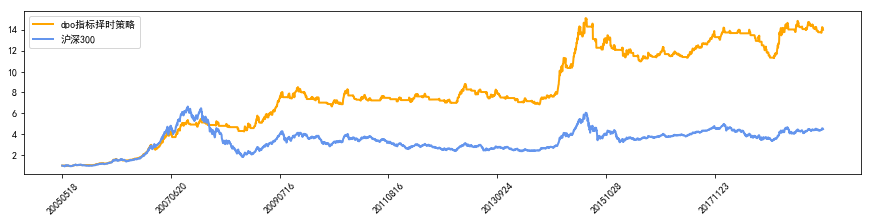

In [69]:
xtick = np.arange(0,df2.shape[0],int(df2.shape[0]/7))
xticklabel = pd.Series(df2.trade_date[xtick])
plt.figure(figsize=(15,3))
fig = plt.axes()
plt.plot(np.arange(df2.shape[0]),df2.nav,label = 'dpo指标择时策略',linewidth =2,color = 'orange')
plt.plot(np.arange(df2.shape[0]),df2.close/df2.close[0],color = 'cornflowerblue',label = '沪深300',linewidth = 2)
fig.set_xticks(xtick)
fig.set_xticklabels(xticklabel,rotation = 45)
plt.legend()
plt.show()